In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime
import tensorflow as tf
import random
import os

## Parameters

In [17]:
# Constants
NUM_ACTIONS = 2 # 0 -> long, 1 -> close
ACTION_LONG = 0
ACTION_CLOSE = 1

# Adjustable Parameters
num_history = 25 # h number of price changes, page 24
state_dimension = num_history + 1 # state representation, h number of price changes and current position, page 24
comm_percent = 0.2 * 0.01 # 0.2%

'''
PARAMETERS TO CHANGE
'''
# start_state_num =  price_index_to_start_reinforcement_learning - num_history
start_state_num = 2100
# number of days to reinforcemently-trade
duration = 700

# Important
stock_symbol = 'gs'
risk_level = 1
# Load model?
train_model = True
save_model = True

## Prepping Data

In [18]:
data = pd.read_csv('data/' + stock_symbol + '.csv')

# IMPORTANT first 10 entries are not used. Must account for this during usage 
ma_span = 10
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
data['MA-Close'] = data['Close'].rolling(ma_span).mean()
data = data[ma_span-1:].reset_index(drop=True)
data['MA-Pct-Change'] = (data['MA-Close'].shift(-1) - data['MA-Close']) / data['MA-Close'] * 100

assert(start_state_num + duration + num_history <= len(data) - 1)

### Plot to see bull / bear / catastrophic

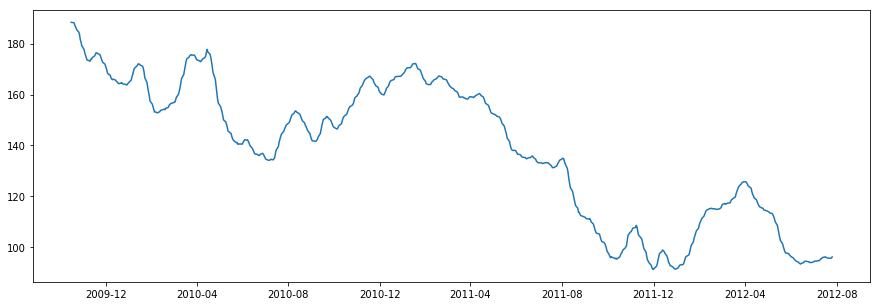

In [19]:
fig =plt.figure(figsize=(15,5))
plt.plot(data['Date'][start_state_num+num_history:start_state_num+num_history+duration], data['MA-Close'][start_state_num+num_history:start_state_num+num_history+duration], figure=fig)

## Plotting related methods

In [5]:
def plot_trading_pattern(trading_pattern, plotter):
    for i in range(len(trading_pattern)):
        if trading_pattern[i] == ACTION_LONG:
            trading_pattern[i] = 1
        else:
            trading_pattern[i] = 0
    plotter.plot(range(start_state_num+num_history, start_state_num+duration+num_history), trading_pattern)
    plotter.fill_between(range(start_state_num+num_history, start_state_num+duration+num_history), trading_pattern)



## Q-Network & related methods

In [6]:
# q network to determine the q value of a state
class Qnetwork():
    def __init__(self, H): # H = neurons in hidden layer
        # 1 x (h+1) shape tensor
        self.x = tf.placeholder(tf.float32, [1, state_dimension]) 
        self.W0 = tf.Variable(tf.random_uniform([state_dimension, H], 0, 0.1))
        self.b0 = tf.Variable(tf.constant(0.1, shape=[H]))
        
        # relu activation function on x*W0 + b0
        self.y_hidden = tf.nn.relu(tf.matmul(self.x, self.W0) + self.b0) 
        
        # output layer only has NUM_ACTIONS number of neurons
        self.W1 = tf.Variable(tf.random_uniform([H, NUM_ACTIONS], 0, 0.1)) 
        self.b1 = tf.Variable(tf.constant(0.1, shape=[NUM_ACTIONS]))  
        
         # calculates q value
        self.q_values = tf.matmul(self.y_hidden, self.W1) + self.b1
        # determine the best action based on q value
        self.best_action = tf.argmax(self.q_values, axis=1) 
        
        # the target reward function to "hopefully" imitate
        self.target = tf.placeholder(tf.float32, [1 ,NUM_ACTIONS]) 
        
        self.loss = tf.reduce_sum(tf.square(self.target - self.q_values))
        self.update = tf.train.AdamOptimizer(learning_rate=0.00005).minimize(self.loss)
        

        
# Experience replay, page 27
class experience_buffer:
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
      
    # add new experience to memory
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
             # remove oldest experience from memory to make room for new 
            self.buffer[0:(len(experience) + len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
        
    
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5]) # output size x 5 shaped experience
    
# Most probably mechanism of separate target network, page 28
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder


def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)
        
        

## State related methods

In [7]:
# generate the state representation using state number and has_stock flag
def processState(state_num, has_stock):
    i = state_num
    h_price_changes = data['MA-Pct-Change'][i:i+num_history].as_matrix()
    state_representation = np.append(h_price_changes, int(has_stock))
    return np.reshape(state_representation, (1, state_dimension))

# make a copy and reshape? 
def norm_state(state):
    temp = state.copy()
    return np.reshape(temp, (1, state_dimension))

# reward structure, page 25

def get_reward(state_num, state, action):
    price_i = state_num + num_history # KIV
    if action == ACTION_LONG:
        if has_stock(state):
            return 0
        else:
            # no stock, so need to buy -> comission
            reward = data['MA-Close'][price_i+1] - data['MA-Close'][price_i] - comm_percent * data['MA-Close'][price_i]
            return reward
        
    else:
        if has_stock(state):
            reward = data['MA-Close'][price_i] - data['MA-Close'][price_i+1] - comm_percent * data['MA-Close'][price_i] 
            return reward
        else:
            return 0

'''def get_reward(px, state, action):
    temp_comm_percent = comm_percent * 7
    px = px + num_history
    if action == ACTION_LONG: # long
        if has_stock(state):
            comm = 0
        else:
            comm = temp_comm_percent * data['MA-Close'][px]
        reward = data['MA-Close'][px + 1] - data['MA-Close'][px] - comm
    else: # close
        if has_stock(state):
            reward = -temp_comm_percent * data['MA-Close'][px]
        else:
            reward = 0

    reward = (reward /data['MA-Close'][px]) * 100

    # if reward > 0:
    #     reward *= (1 + risk_level)
    # else:
    #     reward *= (1 - risk_level)

    return reward'''

def get_action(q_values):
    return np.argmax(q_values)

def has_stock(state):
    # checks state representation if state has stock
    return (state[0, state_dimension-1] == 1)


def get_next_state(current_state_num, current_state_action):
    if current_state_action == ACTION_LONG:
        own_stock = True
    else:
        own_stock = False
    return processState(current_state_num+1, own_stock)

## Trading pattern related methods

In [8]:
def calculate_profit(trading_pattern, start_state_num):
    bought = False
    profit = 0
    for i in range(len(trading_pattern)):
        action = trading_pattern[i]
        
        # first 25 prices are ignored because they are no actions on those days
        price_on_day = data['Close'][start_state_num + i + num_history]
        
        if action == ACTION_LONG:
            if not bought:
                # Buying of stock
                bought = True
                profit -= price_on_day
                profit -= comm_percent * price_on_day
                
        else:
            if bought:
                # Selling of stock
                bought=False
                profit += price_on_day
                profit -= comm_percent * price_on_day
    
    # If still holding a stock at the end of the trading_pattern
    # add current value of stock to profit
    if bought == True:
        profit += price_on_day        
    return profit

def get_long_percentage(trading_pattern):
    total = len(trading_pattern)
    
    # because ACTION_CLOSE = 1
    long_num = total - np.sum(trading_pattern)
    return float(long_num) / total

def get_avg_distance_trades(trading_pattern):
    prev_action = ACTION_CLOSE
    distances = []
    start = 0
    
    for i in range(len(trading_pattern)):
        if trading_pattern[i] == ACTION_LONG and prev_action == ACTION_CLOSE:
            prev_action = ACTION_LONG
            start = i
        elif trading_pattern[i] == ACTION_CLOSE and prev_action == ACTION_LONG:
            prev_action = ACTION_CLOSE
            distances.append(i-start)
            
    return np.mean(distances)


#def plot_trading_pattern()

## Training Parameters

In [9]:
batch_size = 32
update_freq = 10
gamma = 0.99
startE = 1
endE = 0.1
annealing_steps = 5000
num_episodes = 450
pre_train_steps = 150000




h_size = 100
tau = 0.0005
model_dir = "./models/" + stock_symbol + "_" + str(risk_level) + '/'
trading_patterns_dir = "./trading_patterns/"

#Make a path for our model to be saved in.
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
if not os.path.exists(trading_patterns_dir):
    os.makedirs(trading_patterns_dir)

## Main Code

In [10]:
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)
saver = tf.train.Saver()

init = tf.global_variables_initializer()
trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)
myBuffer = experience_buffer()

#Set the rate of random action decrease.
e = startE
stepDrop = (startE - endE)/annealing_steps


### Train New Model

Episode 0, Reward 0.000000, Profit 0.000000
0.5085714285714286


c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


0.4757142857142857
0.5
0.4857142857142857
0.48428571428571426
0.5271428571428571
0.47714285714285715
0.5314285714285715
0.4857142857142857
0.4642857142857143
Episode 10, Reward -85.501657, Profit -101.803587
0.4928571428571429
0.5114285714285715
0.5114285714285715
0.4828571428571429
0.49857142857142855
0.4942857142857143
0.5057142857142857
0.46285714285714286
0.5
0.4928571428571429
Episode 20, Reward -86.080206, Profit -71.690474
0.5028571428571429
0.4942857142857143
0.5042857142857143
0.5
0.51
0.48428571428571426
0.49714285714285716
0.4857142857142857
0.49714285714285716
0.5014285714285714
Episode 30, Reward -86.143374, Profit -117.267524
0.4642857142857143
0.46
0.4957142857142857
0.49
0.52
0.49142857142857144
0.46714285714285714
0.5314285714285715
0.5257142857142857
0.52
Episode 40, Reward -83.484586, Profit -100.871441
0.51
0.5085714285714286
0.5271428571428571
0.4957142857142857
0.5014285714285714
0.48857142857142855
0.5157142857142857
0.5085714285714286
0.5057142857142857
0.512857

0.9428571428571428
0.9671428571428572
Episode 380, Reward -18.367214, Profit -39.908805
0.9585714285714285
0.9457142857142857
0.9528571428571428
0.95
0.9571428571428572
0.9628571428571429
0.9414285714285714
0.9442857142857143
0.9471428571428572
0.9657142857142857
Episode 390, Reward -15.654464, Profit -43.570689
0.9557142857142857
0.9428571428571428
0.9328571428571428
0.9471428571428572
0.9528571428571428
0.95
0.9528571428571428
0.9528571428571428
0.94
0.9428571428571428
Episode 400, Reward -18.195937, Profit -42.738835
0.9385714285714286
Saved model
0.9471428571428572
0.9528571428571428
0.9457142857142857
0.94
0.9442857142857143
0.9485714285714286
0.9428571428571428
0.9485714285714286
0.9585714285714285
Episode 410, Reward -18.230927, Profit -45.146194
0.9442857142857143
0.9471428571428572
0.9385714285714286
0.9485714285714286
0.95
0.9614285714285714
0.9585714285714285
0.9514285714285714
0.9514285714285714
0.9271428571428572
Episode 420, Reward -16.794284, Profit -42.868384
0.97
0.961

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

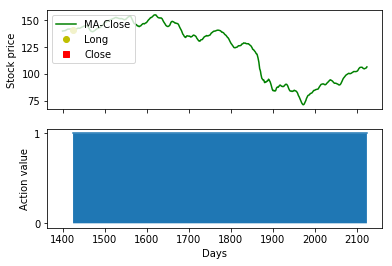

In [11]:
if train_model:
    with tf.Session() as sess:

        sess.run(init)

        updateTarget(targetOps, sess)
        total_steps = 0
        rAll = 0
        profit = 0
        reward_arr = []

        for i in range(num_episodes):
            reward_arr.append(rAll / ((i % 10) + 1))

            # Show average results per 10 episodes
            if i % 10 == 0:
                print("Episode %d, Reward %f, Profit %f" % (i, rAll / 10, profit / 10))
                rAll = 0
                profit = 0

            episodeBuffer = experience_buffer()


            current_state = processState(start_state_num, False)
            trading_pattern = []

            for current_state_num in range(start_state_num, start_state_num+duration):

                # if choose exploration (exploration vs exploitation) or less than pre_train_steps (generate experience)
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    action = np.random.randint(0, 2)
                else:
                    q_values = sess.run(mainQN.q_values, feed_dict={mainQN.x: norm_state(current_state)})
                    action = get_action(q_values)

                trading_pattern.append(action)
                r = get_reward(current_state_num, current_state, action)
                rAll += r

                next_state = get_next_state(current_state_num, action)
                next_state_num = current_state_num + 1

                # investigate this
                episodeBuffer.add(np.reshape(np.array([current_state, action, r, next_state, next_state_num == duration + start_state_num]), [1, 5]))

                # if on the last day to reinforcemently-trade in this episode, calculate profit from this trading pattern
                if next_state_num == start_state_num + duration:
                    profit += calculate_profit(trading_pattern, start_state_num)
                    print(get_long_percentage(trading_pattern))


                total_steps += 1
                if total_steps > pre_train_steps:
                    if e > endE:
                        e -= stepDrop

                    if total_steps % update_freq == 0:
                        train_batch = myBuffer.sample(batch_size)

                        for tb in range(batch_size):
                            Q1 = sess.run(mainQN.q_values, feed_dict={mainQN.x: norm_state(train_batch[tb, 0])})
                            Q2 = sess.run(targetQN.q_values, feed_dict={targetQN.x: norm_state(train_batch[tb,3])})
                            end_multiplier = 1 - train_batch[tb, 4]
                            target = train_batch[tb, 2] + end_multiplier * gamma * np.max(Q2)
                            temporal_difference = target - Q1[0, train_batch[tb, 1]]
                            if temporal_difference > 0:
                                target = target + temporal_difference * risk_level
                            else:
                                target = target - temporal_difference * risk_level
                            Q1[0, train_batch[tb, 1]] = target

                            sess.run(mainQN.update, feed_dict={mainQN.target: Q1, mainQN.x: norm_state(train_batch[tb, 0])})
                        updateTarget(targetOps, sess)
                current_state = next_state
            myBuffer.add(episodeBuffer.buffer)

            if i == num_episodes - 1 or (i % 50 == 0 and i > 200):
                saver.save(sess,model_dir+'model.cptk')
                print("Saved model")

### Run Trained Model
if save_model:
    with tf.Session() as sess:
        print('Loading model')
        ckpt = tf.train.get_checkpoint_state(model_dir)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
        rAll = 0
        trading_pattern = []
        trading_buy_x = []
        trading_buy_y = []
        trading_sell_x = []
        trading_sell_y = []
        current_state = processState(start_state_num, False)
        prev_action = ACTION_CLOSE

        for current_state_num in range(start_state_num, start_state_num + duration):
            qv = sess.run(mainQN.q_values, feed_dict={mainQN.x: norm_state(current_state)})
            action = get_action(qv)
            r = get_reward(current_state_num, current_state, action)
            rAll += r
            trading_pattern.append(action)
            
            if action == ACTION_LONG:
                if prev_action == ACTION_CLOSE:
                    # trading_buy_x = Day 
                    trading_buy_x.append(current_state_num + num_history)
                    trading_buy_y.append(data['MA-Close'][current_state_num + num_history])
            else:
                if prev_action == ACTION_LONG:
                    trading_sell_x.append(current_state_num + num_history)
                    trading_sell_y.append(data['MA-Close'][current_state_num + num_history])
            prev_action = action
            current_state = get_next_state(current_state_num, action)
            
            
        data['trading_action'] = np.nan
        data['trading_action'][start_state_num + num_history:start_state_num + duration + num_history] = trading_pattern
        data.to_csv(trading_patterns_dir + stock_symbol +'_'+str(risk_level)+'_'+str(start_state_num+num_history)+'_to_' + str(start_state_num+duration+num_history) + '.csv', index=False)
        
        print(trading_pattern)
        print(trading_buy_x)
        print(trading_sell_x)
        print(rAll)
        _, axarr = plt.subplots(2, sharex=True)
        print(calculate_profit(trading_pattern, start_state_num))
        print("Long percentage: %f" % (get_long_percentage(trading_pattern)))
        print("Avg days: %f" % (get_avg_distance_trades(trading_pattern)))
        axarr[0].plot(range(start_state_num, start_state_num+duration+num_history), data['MA-Close'][start_state_num:start_state_num+duration+num_history], 'g')
        axarr[0].plot(trading_buy_x, trading_buy_y, 'yo', label='Long')
        axarr[0].plot(trading_sell_x, trading_sell_y, 'rs', label='Close')
        axarr[0].legend(loc='upper left')
        axarr[0].set_ylabel('Stock price')
        axarr[1].set_xlabel('Days')
        axarr[1].set_ylabel('Action value')
        axarr[1].set_yticks([0, 1])
        plot_trading_pattern(trading_pattern, axarr[1])
        plt.show()